In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
from torchvision import transforms
from torchvision.datasets import MNIST

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from IPython import display
import os
from scipy.misc import imread

In [2]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        output = self.fc1(x)
        output = F.relu(output)
        output = self.out(output)
        return output

In [3]:
train_loader = DataLoader(MNIST('mnist-data/', train=True, download=True,
                               transform=transforms.Compose([transforms.ToTensor(),])),
                          batch_size=128, shuffle=True)
test_loader = DataLoader(MNIST('mnist-data/', train=False, 
                               transform=transforms.Compose([transforms.ToTensor(),])),
                        batch_size=128, shuffle=True)

In [4]:
net = MLP(28*28, 1024, 10)

In [5]:
import pyro
from pyro.distributions import Normal, Categorical
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam

In [6]:
log_softmax = nn.LogSoftmax(dim=1)

In [7]:
def model(x_data, y_data):
    fc1w_prior = Normal(loc=torch.zeros_like(net.fc1.weight), scale=torch.ones_like(net.fc1.weight))
    fc1b_prior = Normal(loc=torch.zeros_like(net.fc1.bias), scale=torch.ones_like(net.fc1.bias))
    
    outw_prior = Normal(loc=torch.zeros_like(net.out.weight), scale=torch.ones_like(net.out.weight))
    outb_prior = Normal(loc=torch.zeros_like(net.out.bias), scale=torch.ones_like(net.out.bias))
    
    priors = {'fc1.weight': fc1w_prior, 'fc1.bias': fc1b_prior, 'out.weight': outw_prior,
             'out.bias': outb_prior}
    # Lift module parameters to random variables sampled from the priors
    lifted_module = pyro.random_module('module', net, priors)
    # sample a regressor (which also samples w and b)
    lifted_reg_model = lifted_module()
    
    lhat = log_softmax(lifted_reg_model(x_data))
    
    pyro.sample('obs', Categorical(logits=lhat), obs=y_data)

In [8]:
softplus = torch.nn.Softplus()

In [9]:
def guide(x_data, y_data):
    # First layer weight distribution priors
    fc1w_mu = torch.randn_like(net.fc1.weight)
    fc1w_sigma = torch.randn_like(net.fc1.weight)
    
    fc1w_mu_param = pyro.param('fc1w_mu', fc1w_mu)
    fc1w_sigma_param = softplus(pyro.param('fc1w_sigma', fc1w_sigma))
    fc1w_prior = Normal(loc=fc1w_mu_param, scale=fc1w_sigma_param)
    
    # First layer bias distribution priors
    fc1b_mu = torch.randn_like(net.fc1.bias)
    fc1b_sigma = torch.randn_like(net.fc1.bias)
    
    fc1b_mu_param = pyro.param("fc1b_mu", fc1b_mu)
    fc1b_sigma_param = softplus(pyro.param("fc1b_sigma", fc1b_sigma))
    fc1b_prior = Normal(loc=fc1b_mu_param, scale=fc1b_sigma_param)
    
    # Output layer weight distribution priors
    outw_mu = torch.randn_like(net.out.weight)
    outw_sigma = torch.randn_like(net.out.weight)
    
    outw_mu_param = pyro.param("outw_mu", outw_mu)
    outw_sigma_param = softplus(pyro.param("outw_sigma", outw_sigma))
    outw_prior = Normal(loc=outw_mu_param, scale=outw_sigma_param).independent(1)
    
    # Output layer bias distribution priors
    outb_mu = torch.randn_like(net.out.bias)
    outb_sigma = torch.randn_like(net.out.bias)
    
    outb_mu_param = pyro.param("outb_mu", outb_mu)
    outb_sigma_param = softplus(pyro.param("outb_sigma", outb_sigma))
    outb_prior = Normal(loc=outb_mu_param, scale=outb_sigma_param)
    priors = {'fc1.weight': fc1w_prior, 'fc1.bias': fc1b_prior, 
              'out.weight': outw_prior, 'out.bias': outb_prior}
    
    lifted_module = pyro.random_module('module', net, priors)
    
    return lifted_module()

In [10]:
optim = Adam({'lr': 0.01})
svi = SVI(model, guide, optim, loss=Trace_ELBO())

In [11]:
num_iterations = 5
loss = 0

for j in range(num_iterations):
    loss = 0
    for batch_id, data in enumerate(train_loader):
        # Calculate the loss and take a gradient step
        loss += svi.step(data[0].view(-1, 28*28), data[1])
    normalizer_train = len(train_loader.dataset)
    total_epoch_loss_train = loss / normalizer_train
    
    print("Epoch ", j, "loss ", total_epoch_loss_train)

Epoch  0 loss  2112.342334368237
Epoch  1 loss  388.9643097285112
Epoch  2 loss  165.15841630439758
Epoch  3 loss  114.4506662323316
Epoch  4 loss  97.25513996551831


In [12]:
num_samples = 10
def predict(X):
    sampled_models = [guide(None, None) for _ in range(num_samples)]
    yhats = [model(X).data for model in sampled_models]
    mean = torch.mean(torch.stack(yhats), 0)
    return np.argmax(mean.numpy(), axis=1)

print('Prediction when network is forced to predict')
correct = 0
total = 0
for j, data in enumerate(test_loader):
    images, labels = data
    predicted = predict(images.view(-1, 28*28))
    total += labels.size(0)
    correct += (predicted == labels.numpy()).sum().item()
print('accuracy: %d %%' %(100 * correct / total))

Prediction when network is forced to predict
accuracy: 87 %


In [13]:
classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')

In [14]:
def imshow(img):
    img = img / 2 + 0.5
    np_img = img.numpy()
    
    fig, ax = plt.subplots(figsize=(1, 1))
    ax.imshow(np_img, cmap='gray', interpolation='nearest')
    plt.show()

In [15]:
num_samples = 100
def give_uncertainties(x):
    sampled_models = [guide(None, None) for _ in range(num_samples)]
    yhats = [F.log_softmax(model(x.view(-1, 28*28)).data, 1).detach().numpy() for model in sampled_models]
    return np.asarray(yhats)

In [21]:
def test_batch(images, labels, plot=True):
    y = give_uncertainties(images)
    predicted_for_images = 0
    correct_predictions=0

    for i in range(len(labels)):
    
        if(plot):
            print("Real: ",labels[i].item())
            fig, axs = plt.subplots(1, 10, sharey=True,figsize=(20,2))
    
        all_digits_prob = []
    
        highted_something = False
    
        for j in range(len(classes)):
        
            highlight=False
        
            histo = []
            histo_exp = []
        
            for z in range(y.shape[0]):
                histo.append(y[z][i][j])
                histo_exp.append(np.exp(y[z][i][j]))
            
            prob = np.percentile(histo_exp, 50) #sampling median probability
        
            if(prob>0.2): #select if network thinks this sample is 20% chance of this being a label
                highlight = True #possibly an answer
        
            all_digits_prob.append(prob)
            
            if(plot):
            
                N, bins, patches = axs[j].hist(histo, bins=8, color = "lightgray", lw=0,  weights=np.ones(len(histo)) / len(histo), density=False)
                axs[j].set_title(str(j)+" ("+str(round(prob,2))+")") 
        
            if(highlight):
            
                highted_something = True
                
                if(plot):

                    # We'll color code by height, but you could use any scalar
                    fracs = N / N.max()

                    # we need to normalize the data to 0..1 for the full range of the colormap
                    norm = colors.Normalize(fracs.min(), fracs.max())

                    # Now, we'll loop through our objects and set the color of each accordingly
                    for thisfrac, thispatch in zip(fracs, patches):
                        color = plt.cm.viridis(norm(thisfrac))
                        thispatch.set_facecolor(color)
        if(plot):
            plt.show()
    
        predicted = np.argmax(all_digits_prob)
    
        if(highted_something):
            predicted_for_images+=1
            if(labels[i].item()==predicted):
                if(plot):
                    print("Correct")
                correct_predictions +=1.0
            else:
                if(plot):
                    print("Incorrect :()")
        else:
            if(plot):
                print("Undecided.")
        
        if(plot):
            imshow(images[i].squeeze())
        
    
    if(plot):
        print("Summary")
        print("Total images: ",len(labels))
        print("Predicted for: ",predicted_for_images)
        print("Accuracy when predicted: ",correct_predictions/predicted_for_images)
        
    return len(labels), correct_predictions, predicted_for_images

In [22]:
# Prediction when network can decide not to predict
print('Prediction when network can refuse')
correct = 0
total = 0
total_predicted_for = 0
for j, data in enumerate(test_loader):
    images, labels = data
    
    total_minibatch, correct_minibatch, predictions_minibatch = test_batch(images, labels, plot=False)
    total += total_minibatch
    correct += correct_minibatch
    total_predicted_for += predictions_minibatch

print("Total images: ", total)
print("Skipped: ", total-total_predicted_for)
print("Accuracy when made predictions: %d %%" % (100 * correct / total_predicted_for))

Prediction when network can refuse
Total images:  10000
Skipped:  1377
Accuracy when made predictions: 95 %


In [23]:
# Preparing for evaluation
data = iter(test_loader)
images, labels = data.next()

Real:  4


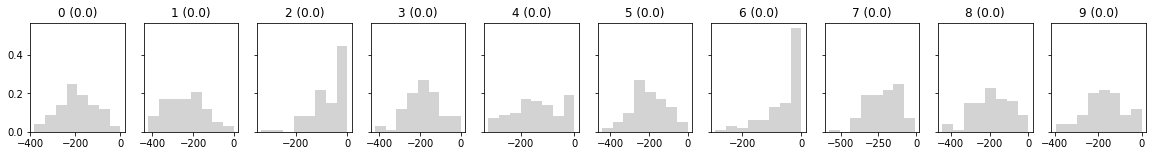

Undecided.


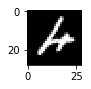

Real:  9


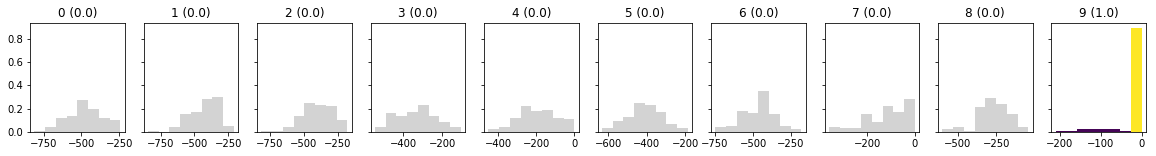

Correct


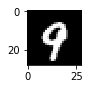

Real:  5


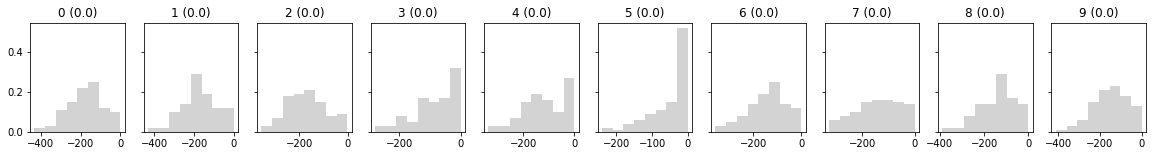

Undecided.


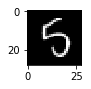

Real:  1


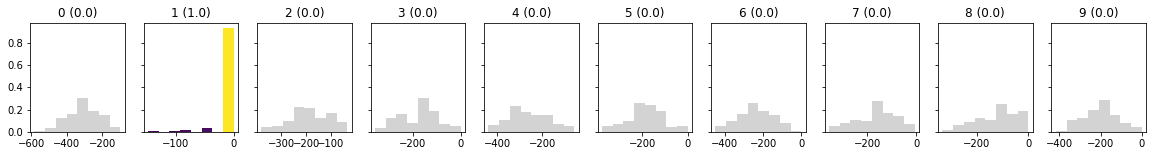

Correct


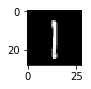

Real:  0


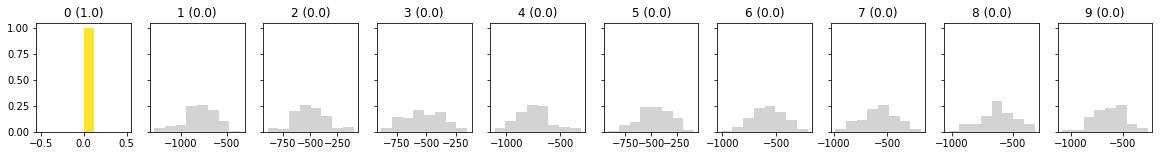

Correct


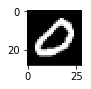

Real:  8


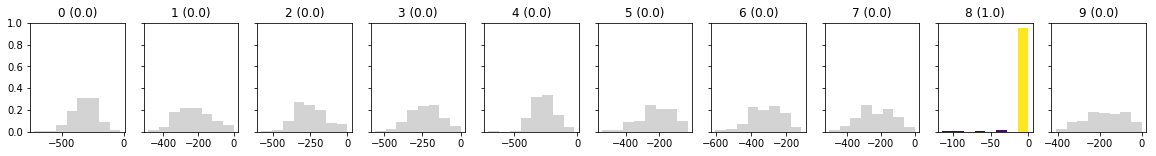

Correct


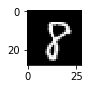

Real:  8


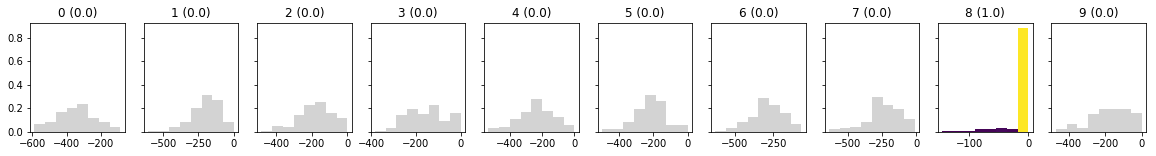

Correct


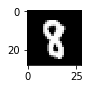

Real:  7


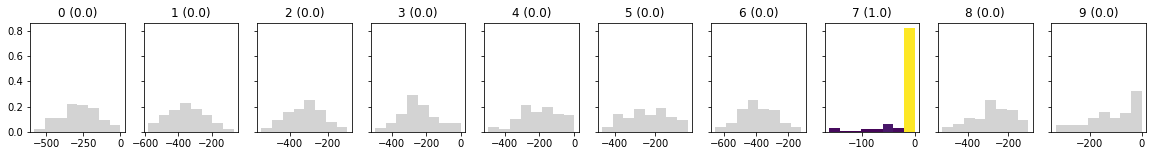

Correct


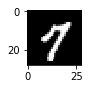

Real:  2


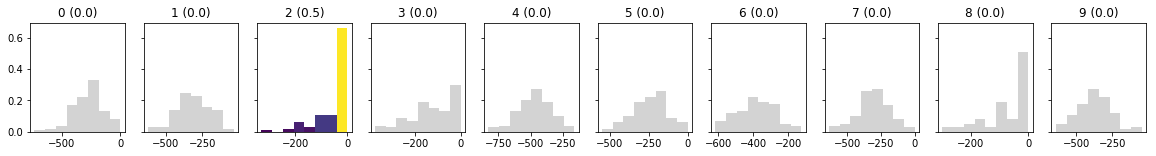

Correct


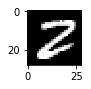

Real:  9


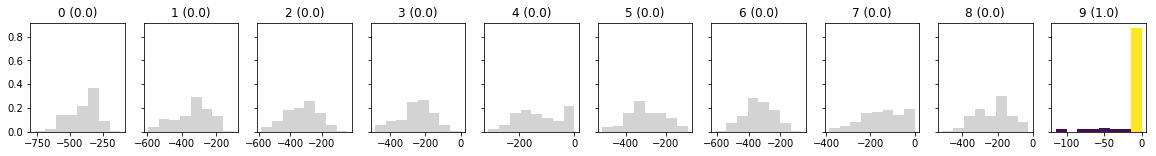

Correct


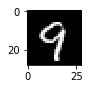

Real:  6


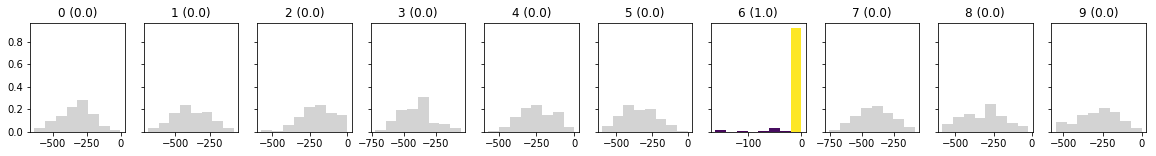

Correct


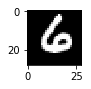

Real:  6


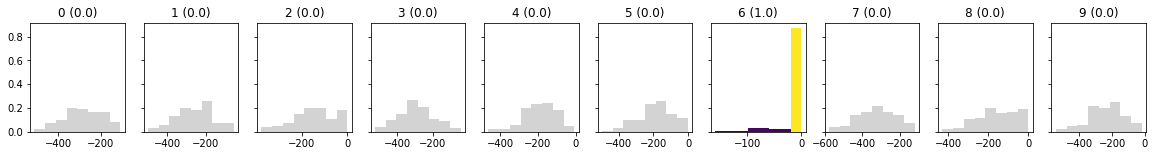

Correct


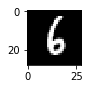

Real:  8


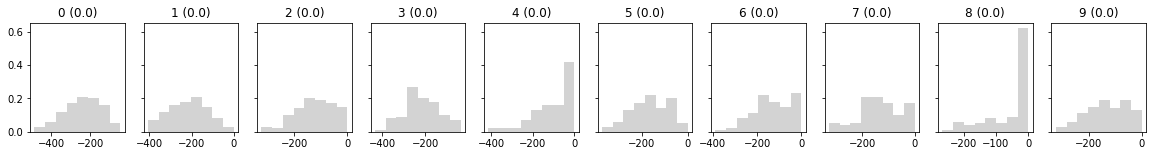

Undecided.


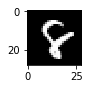

Real:  2


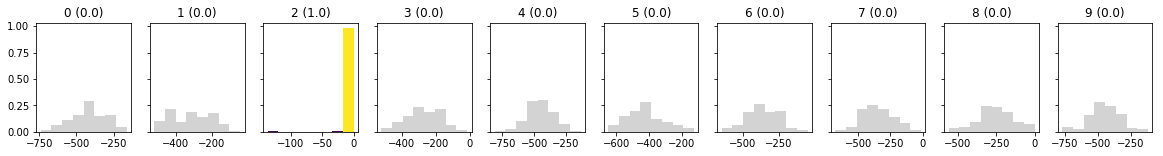

Correct


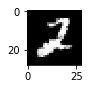

Real:  0


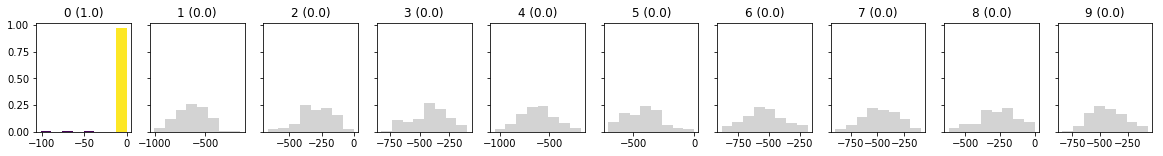

Correct


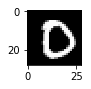

Real:  0


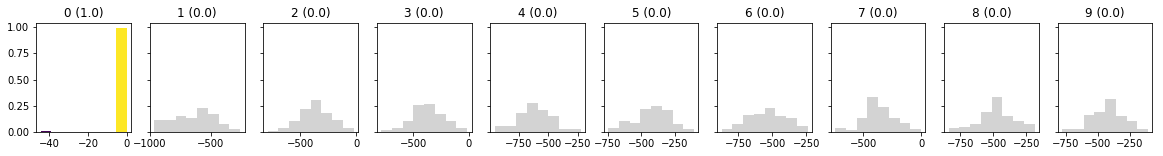

Correct


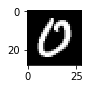

Real:  4


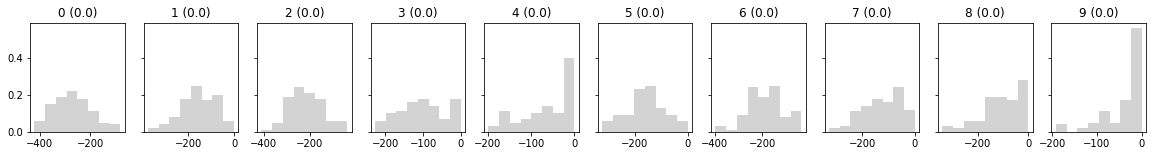

Undecided.


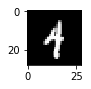

Real:  0


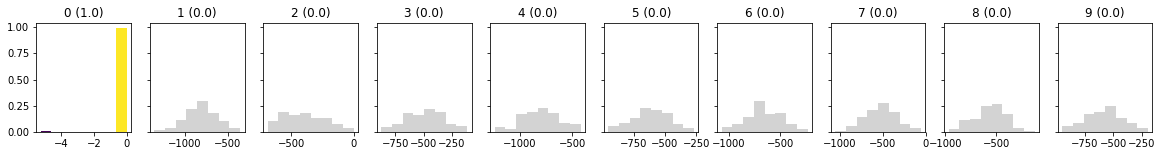

Correct


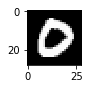

Real:  6


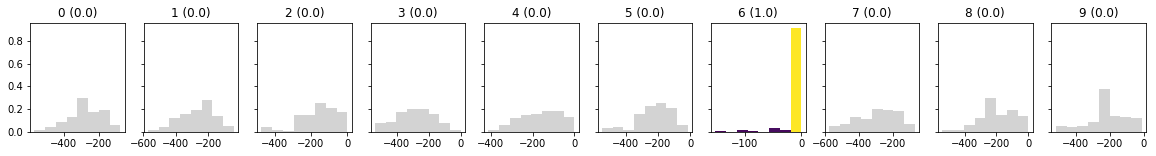

Correct


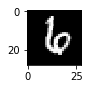

Real:  0


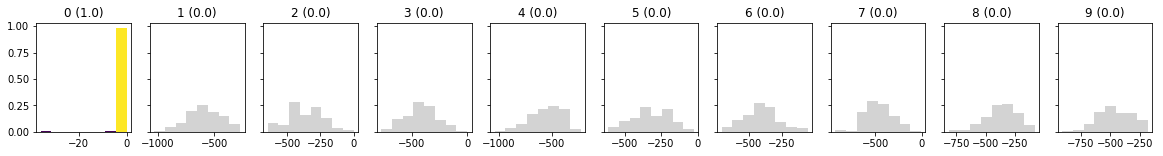

Correct


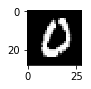

Real:  5


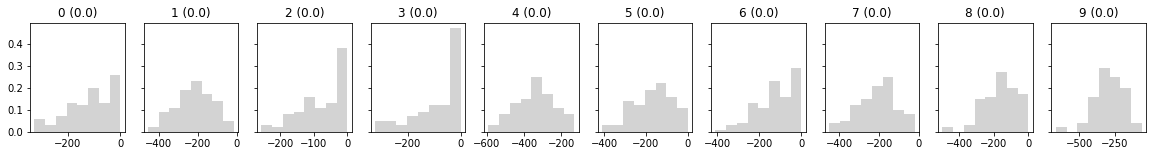

Undecided.


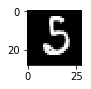

Real:  7


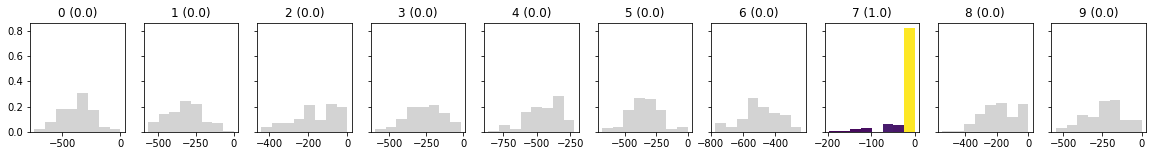

Correct


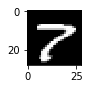

Real:  7


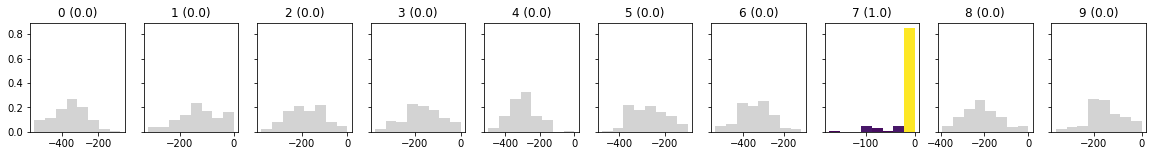

Correct


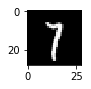

Real:  0


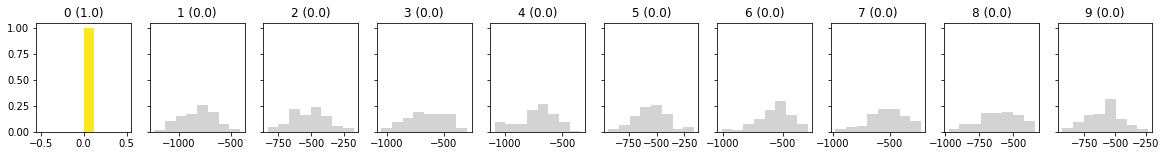

Correct


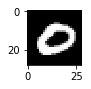

Real:  8


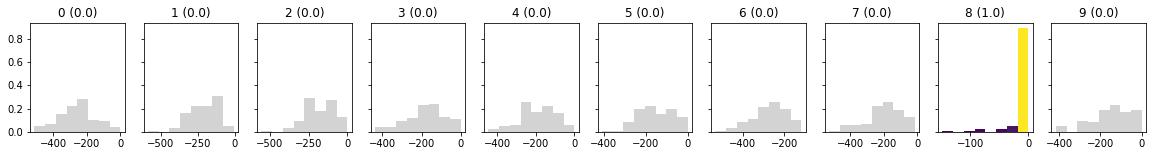

Correct


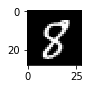

Real:  0


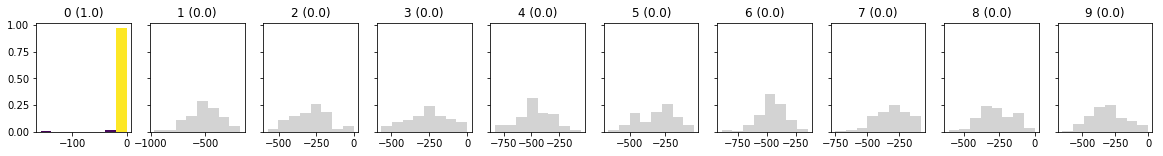

Correct


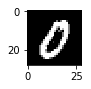

Real:  2


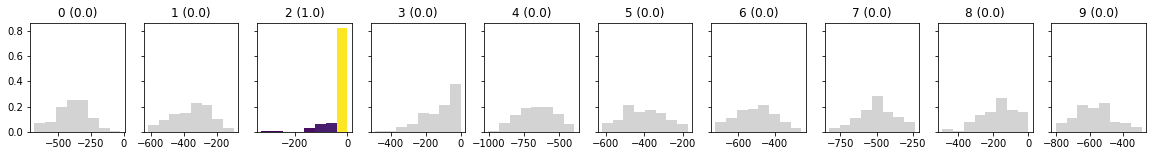

Correct


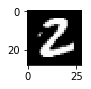

Real:  1


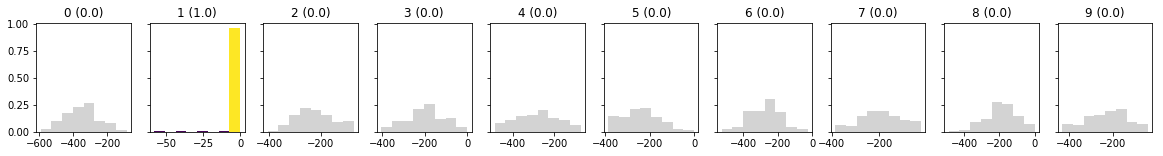

Correct


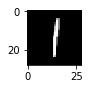

Real:  9


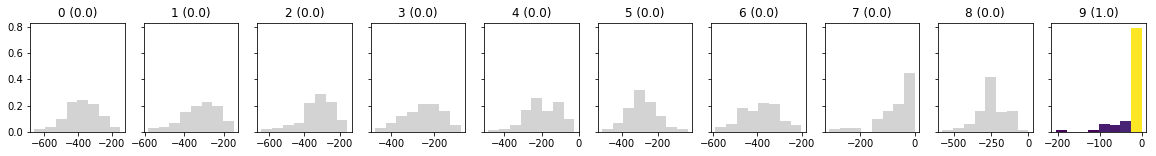

Correct


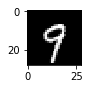

Real:  4


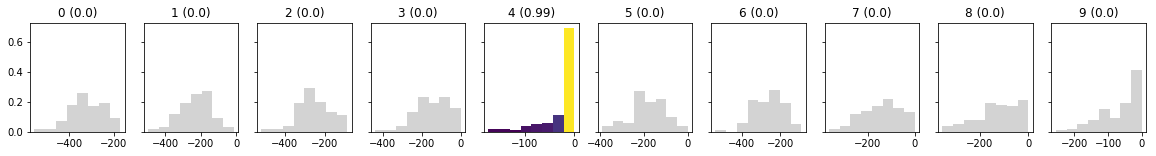

Correct


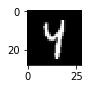

Real:  4


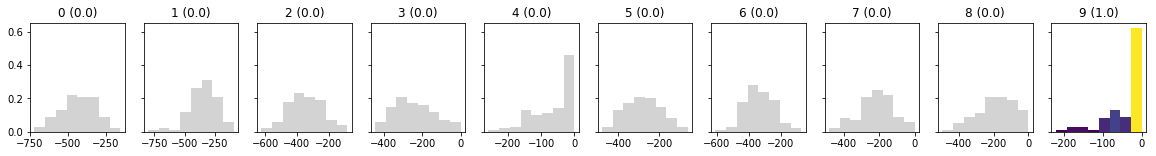

Incorrect :()


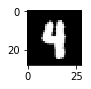

Real:  9


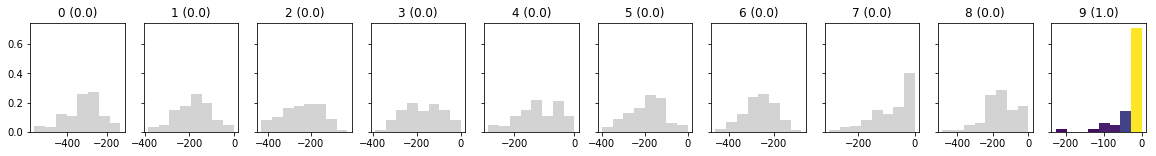

Correct


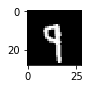

Real:  2


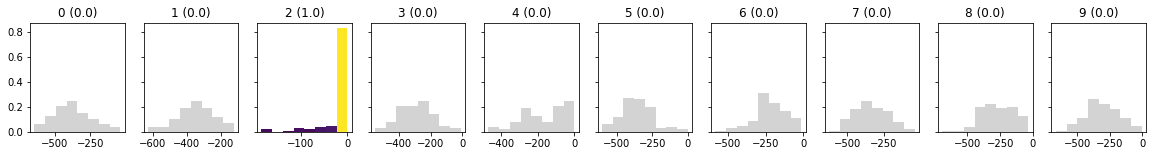

Correct


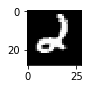

Real:  8


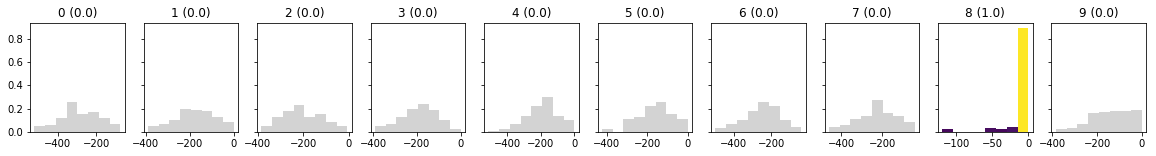

Correct


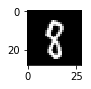

Real:  3


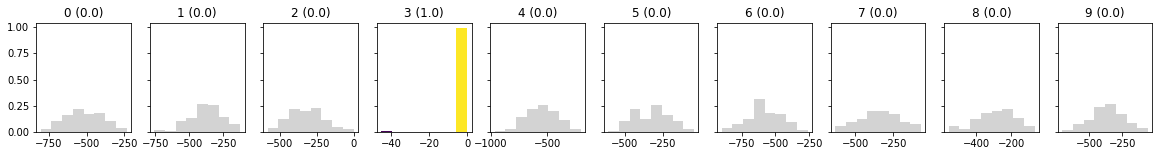

Correct


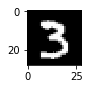

Real:  2


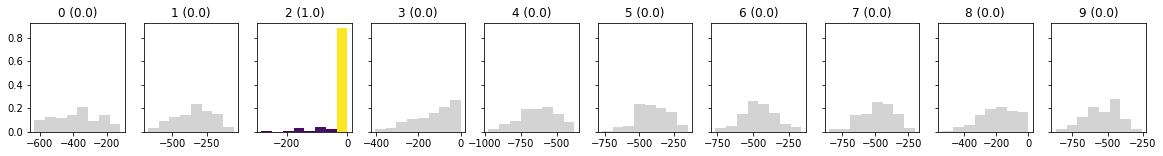

Correct


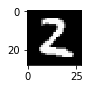

Real:  9


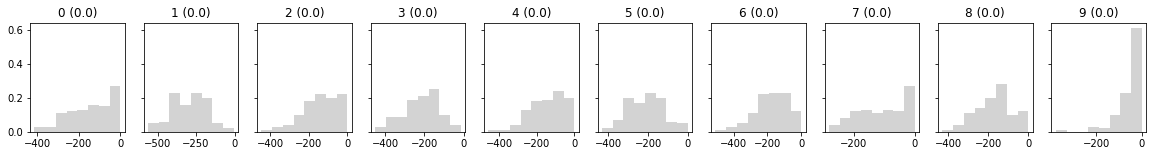

Undecided.


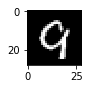

Real:  3


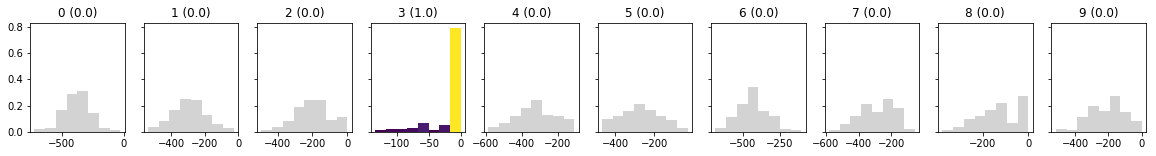

Correct


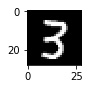

Real:  6


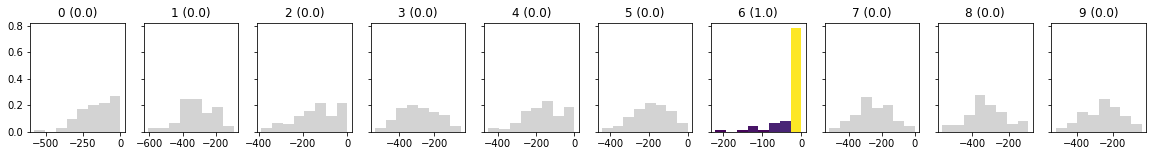

Correct


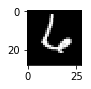

Real:  2


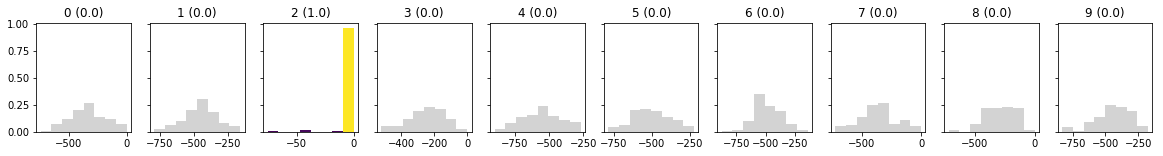

Correct


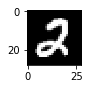

Real:  5


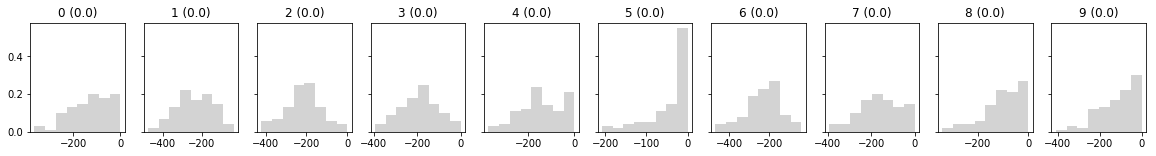

Undecided.


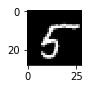

Real:  9


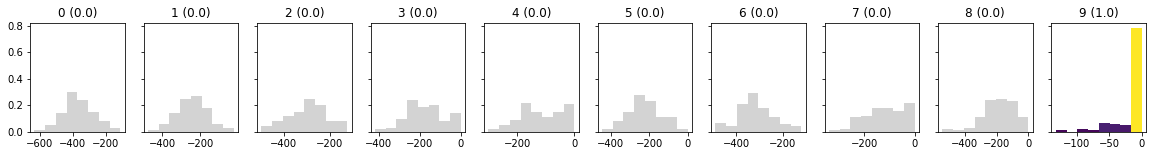

Correct


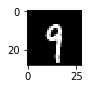

Real:  7


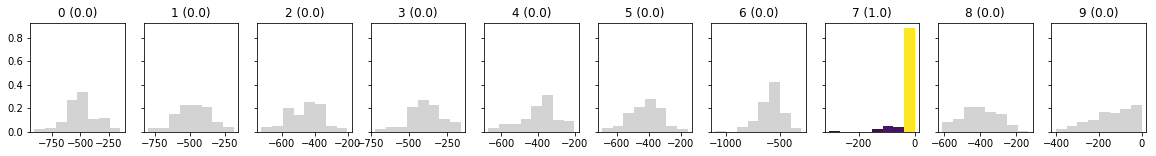

Correct


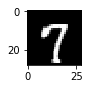

Real:  5


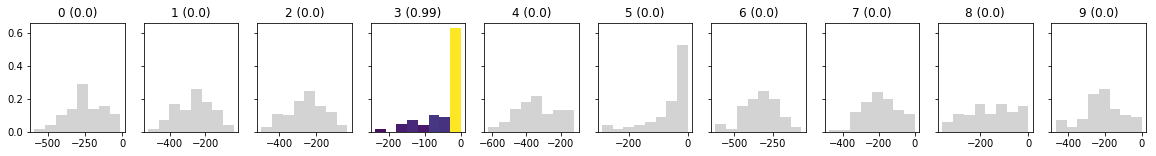

Incorrect :()


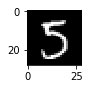

Real:  6


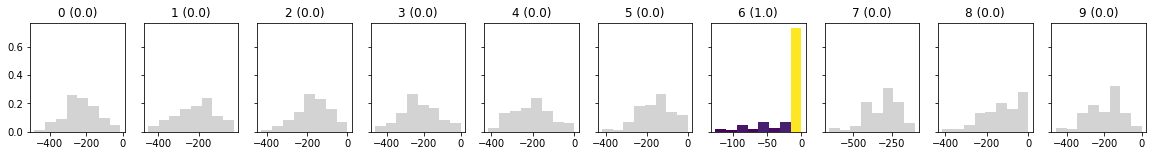

Correct


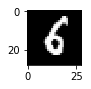

Real:  6


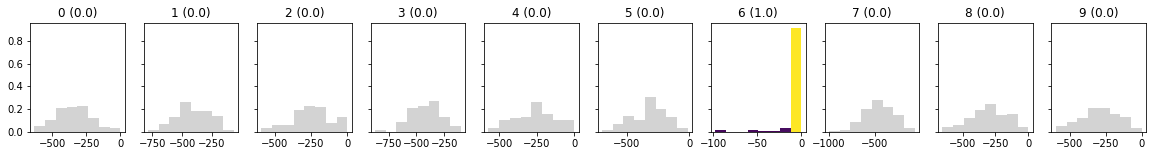

Correct


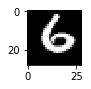

Real:  3


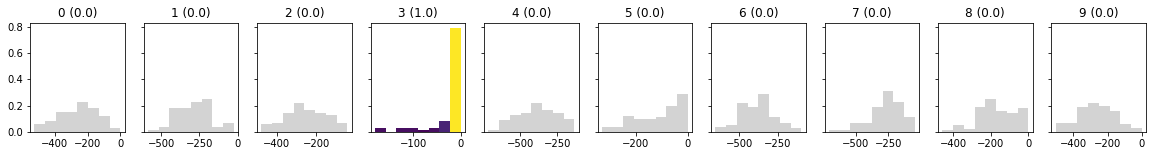

Correct


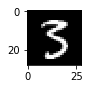

Real:  8


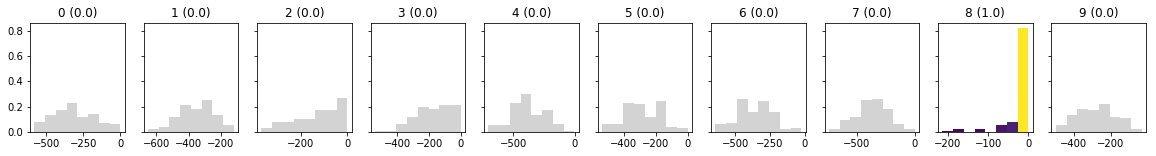

Correct


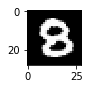

Real:  1


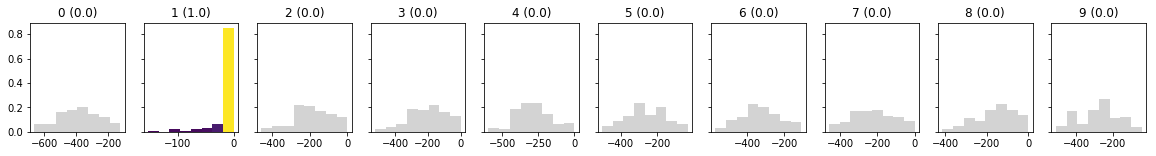

Correct


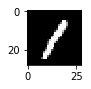

Real:  0


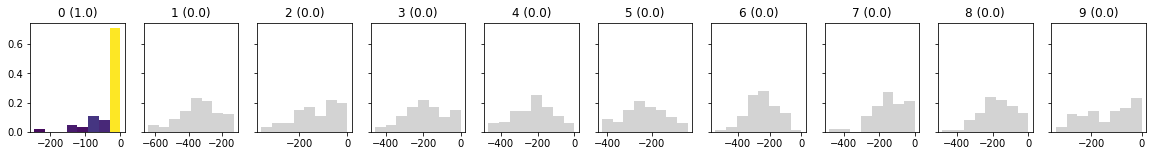

Correct


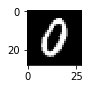

Real:  9


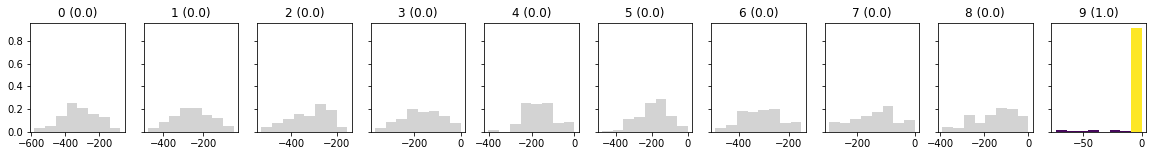

Correct


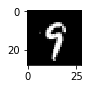

Real:  7


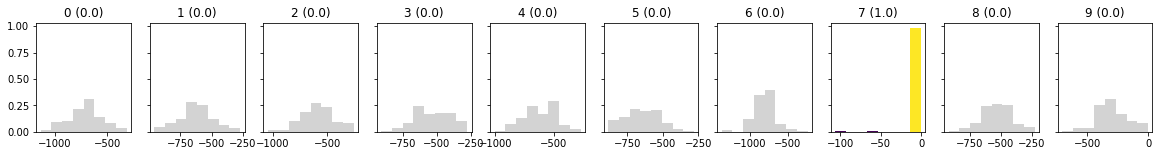

Correct


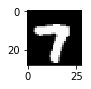

Real:  4


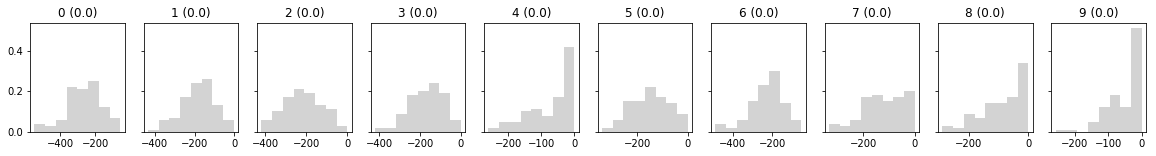

Undecided.


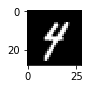

Real:  6


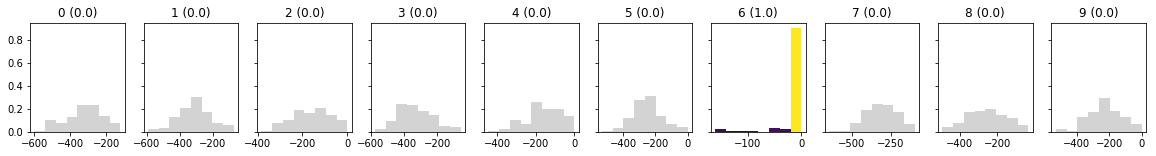

Correct


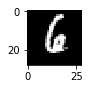

Real:  4


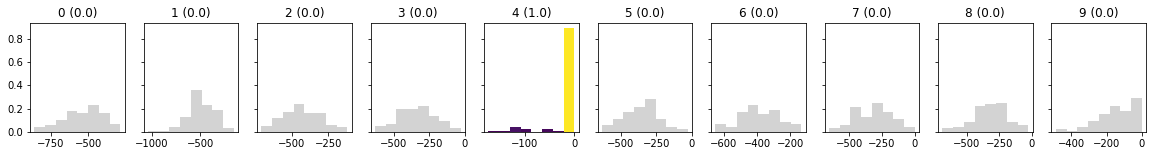

Correct


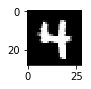

Real:  2


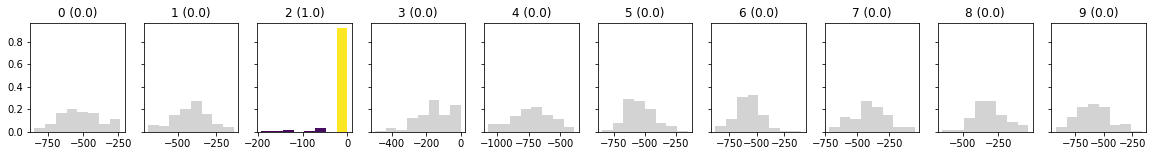

Correct


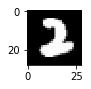

Real:  3


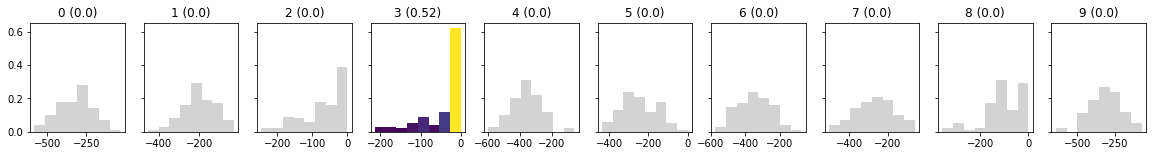

Correct


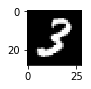

Real:  5


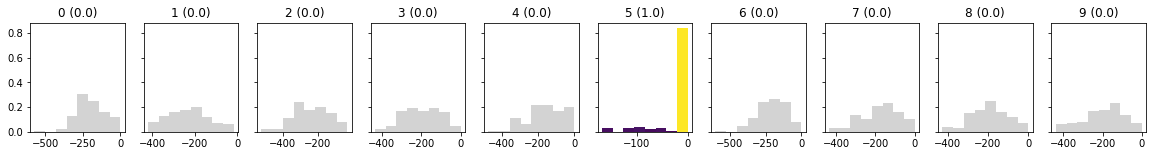

Correct


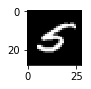

Real:  1


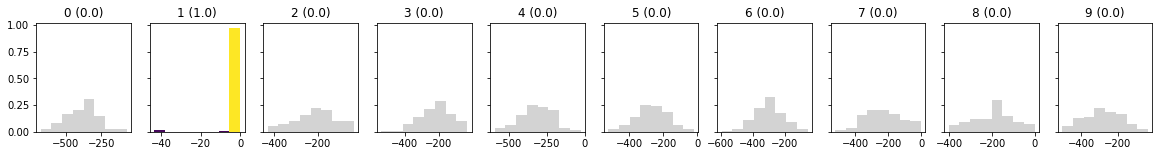

Correct


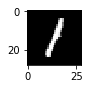

Real:  5


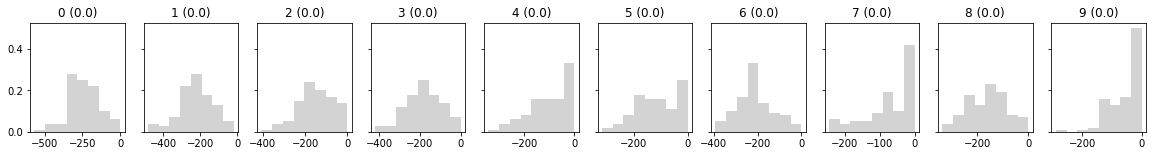

Undecided.


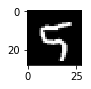

Real:  0


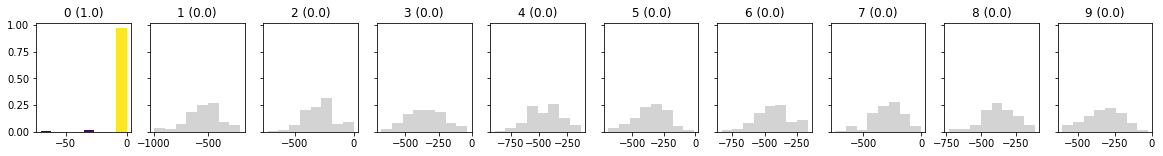

Correct


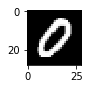

Real:  9


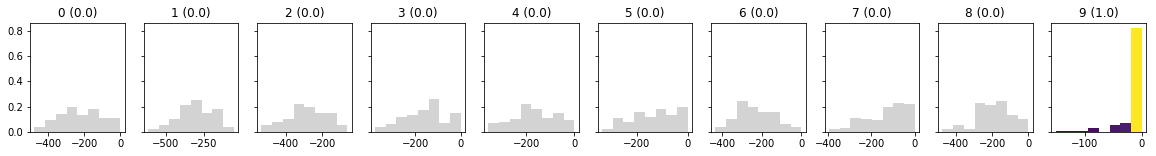

Correct


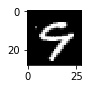

Real:  8


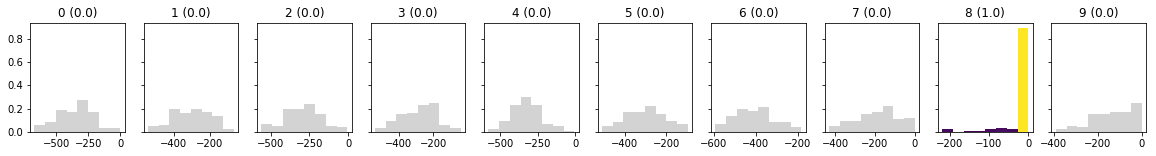

Correct


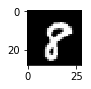

Real:  2


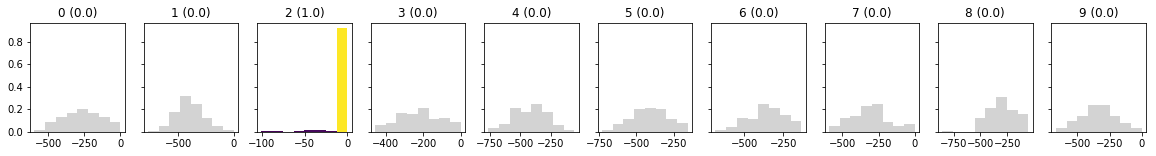

Correct


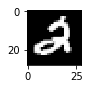

Real:  0


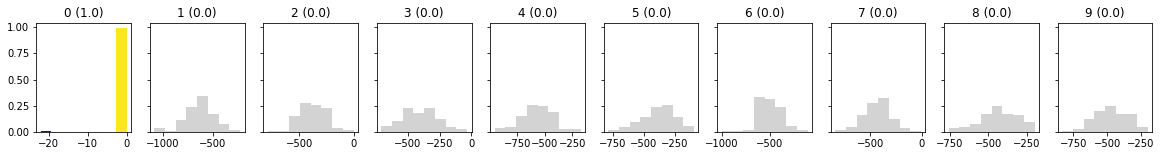

Correct


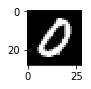

Real:  9


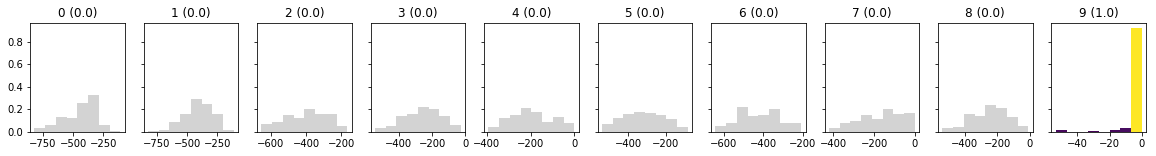

Correct


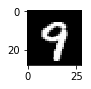

Real:  5


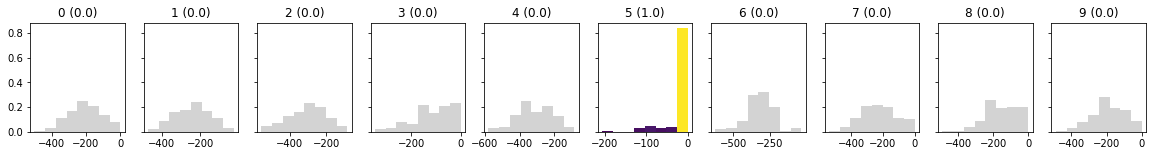

Correct


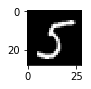

Real:  9


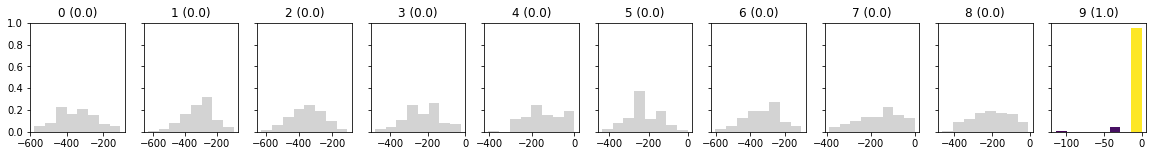

Correct


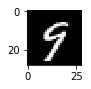

Real:  7


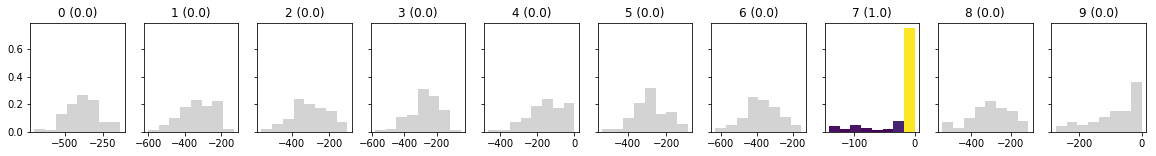

Correct


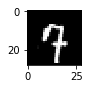

Real:  1


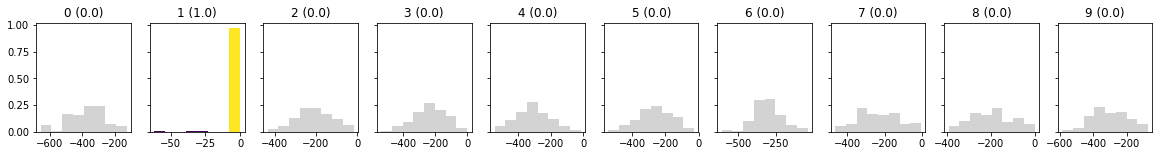

Correct


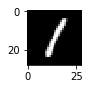

Real:  5


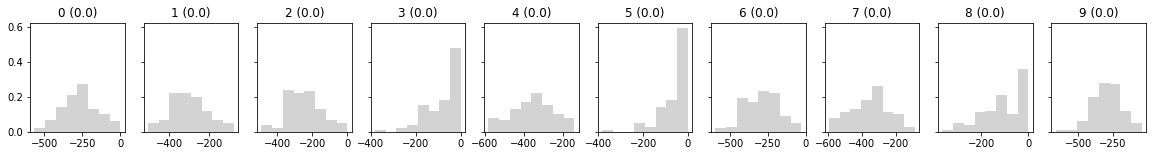

Undecided.


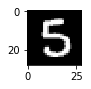

Real:  2


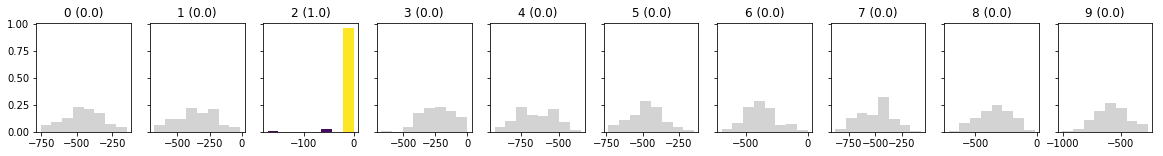

Correct


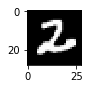

Real:  7


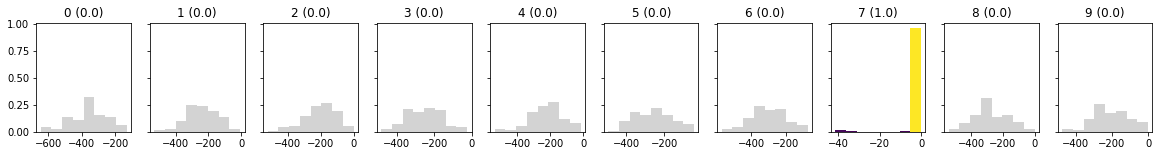

Correct


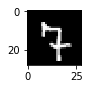

Real:  8


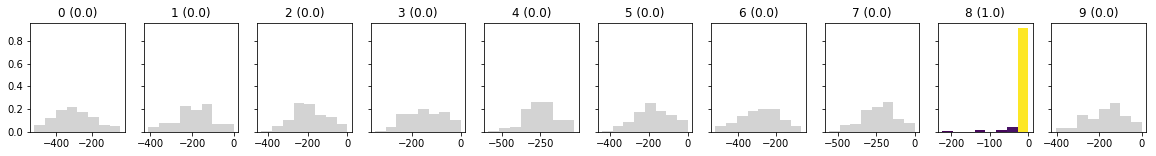

Correct


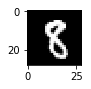

Real:  4


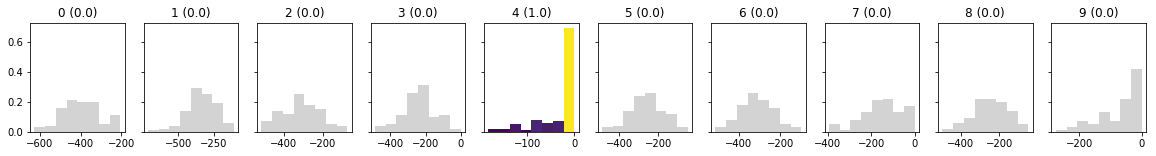

Correct


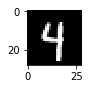

Real:  4


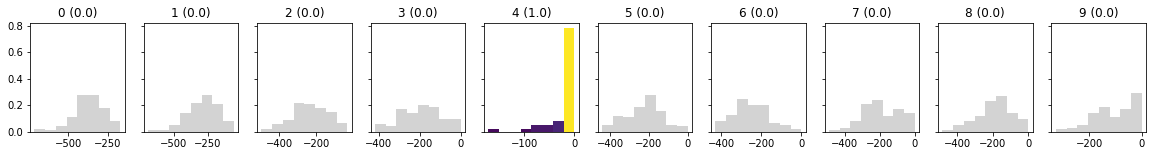

Correct


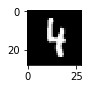

Real:  1


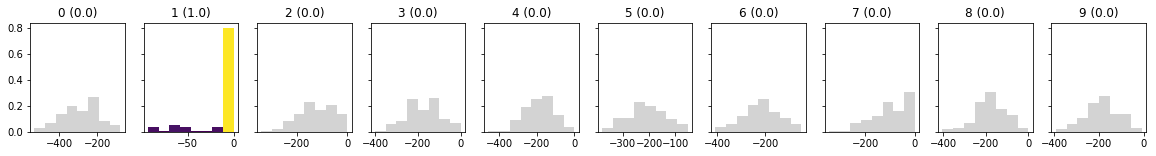

Correct


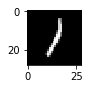

Real:  4


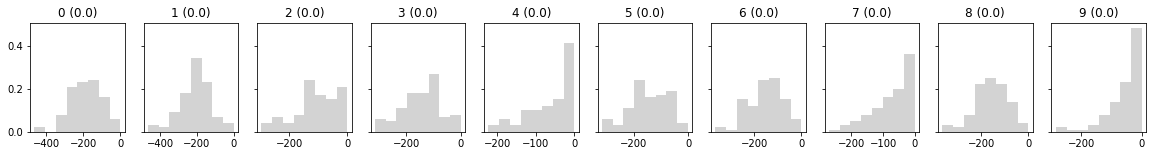

Undecided.


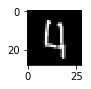

Real:  1


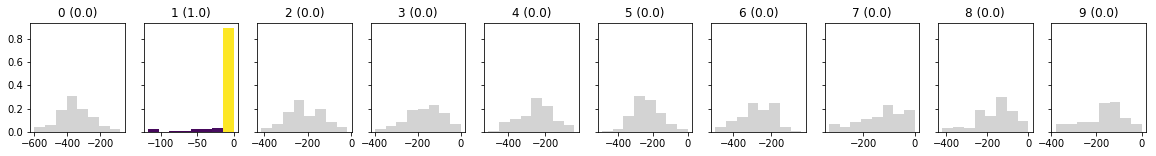

Correct


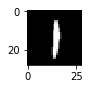

Real:  7


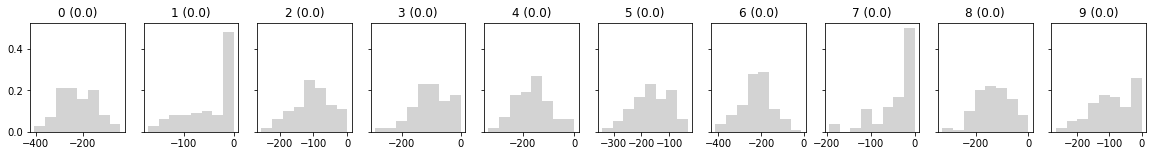

Undecided.


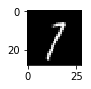

Real:  2


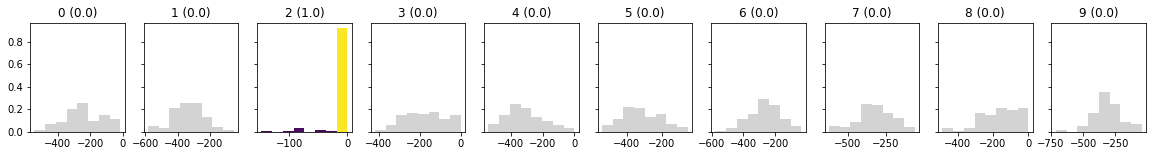

Correct


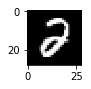

Real:  4


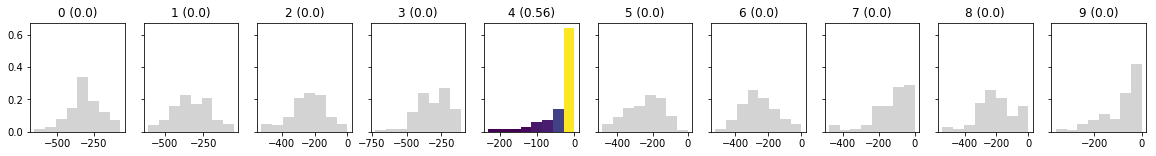

Correct


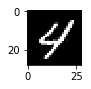

Real:  6


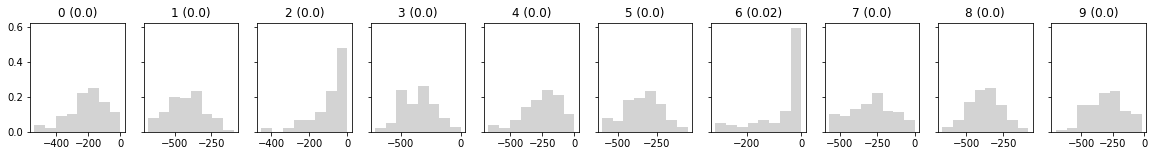

Undecided.


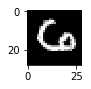

Real:  3


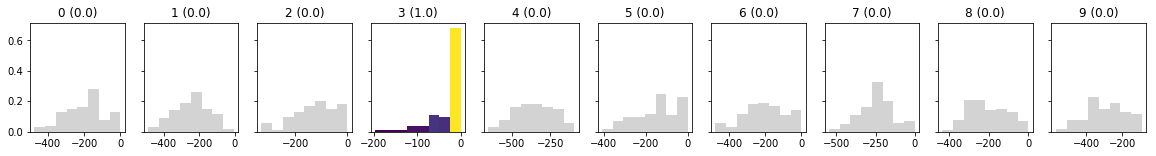

Correct


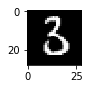

Real:  8


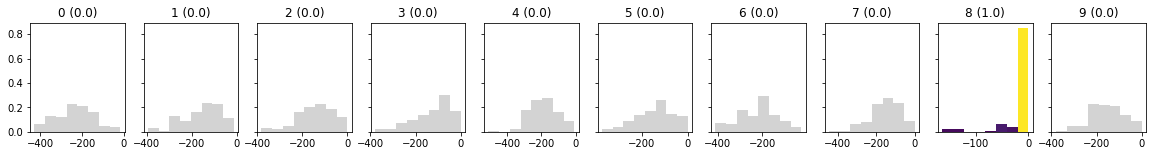

Correct


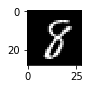

Real:  4


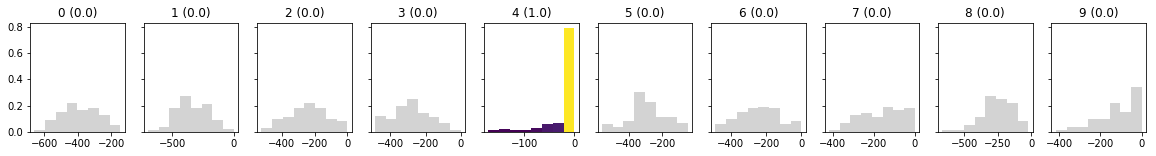

Correct


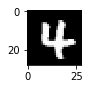

Real:  4


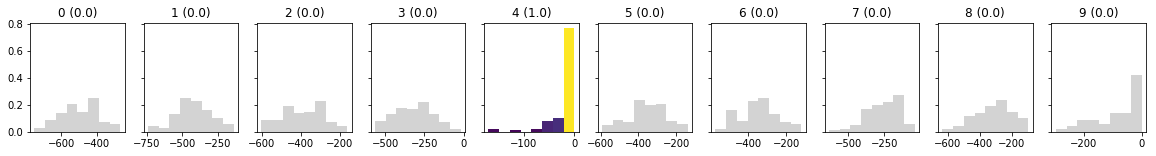

Correct


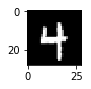

Real:  6


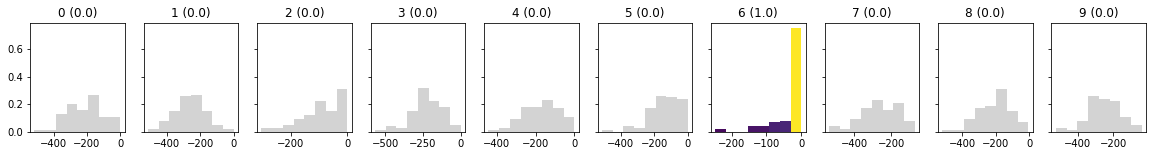

Correct


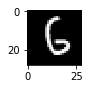

Real:  9


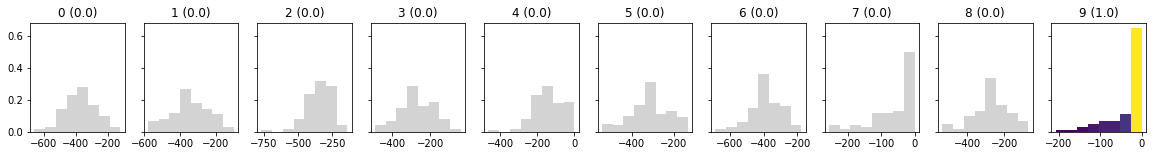

Correct


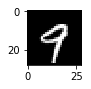

Real:  4


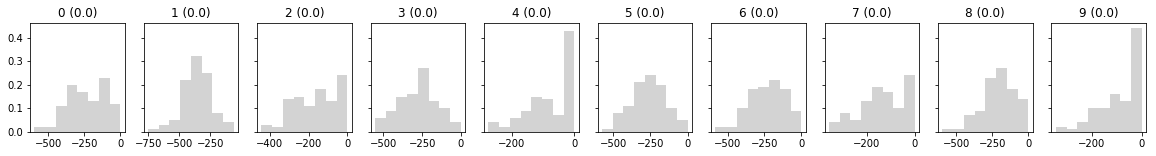

Undecided.


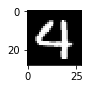

Real:  2


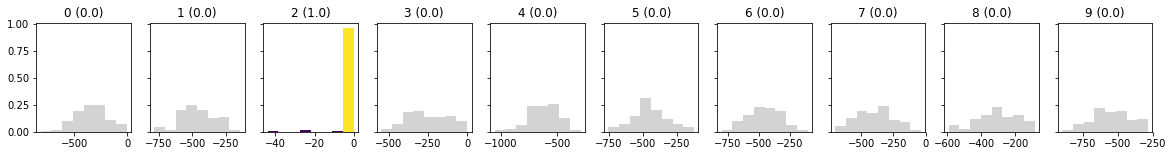

Correct


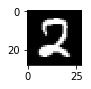

Real:  9


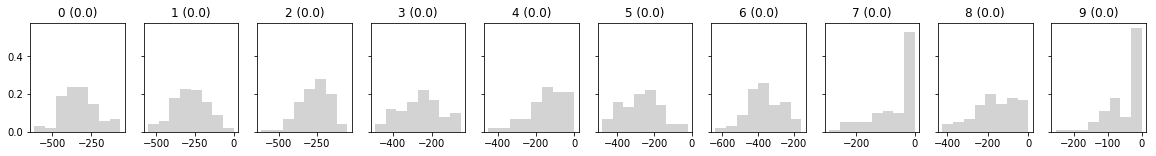

Undecided.


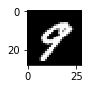

Real:  4


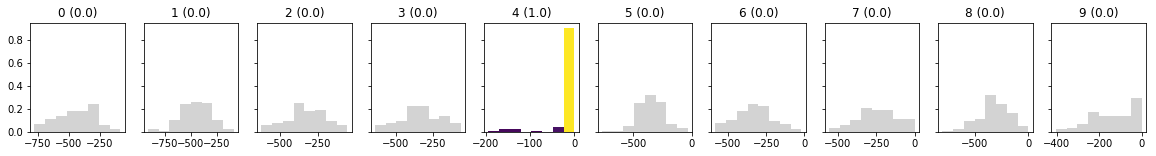

Correct


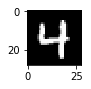

Real:  4


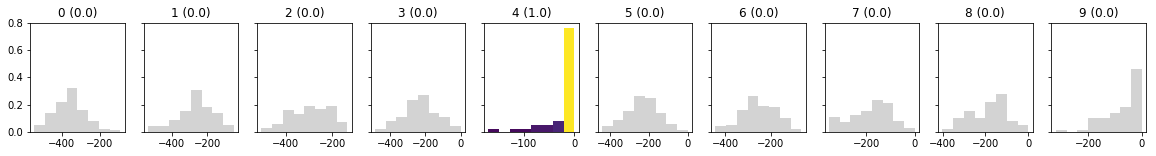

Correct


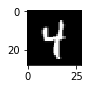

Real:  8


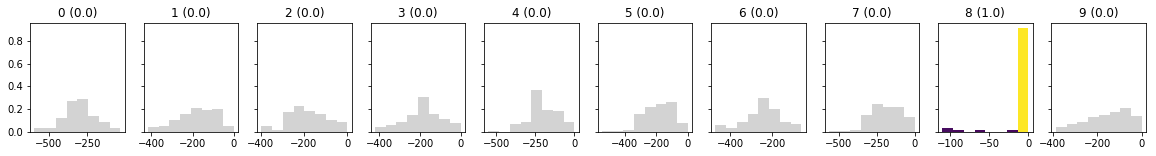

Correct


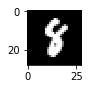

Real:  4


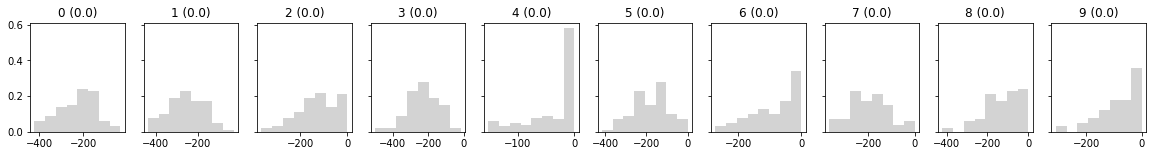

Undecided.


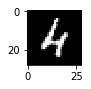

Real:  2


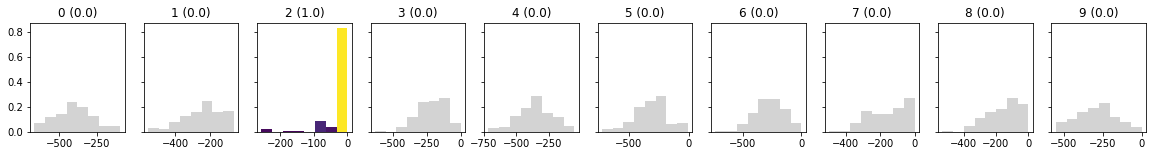

Correct


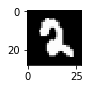

Real:  6


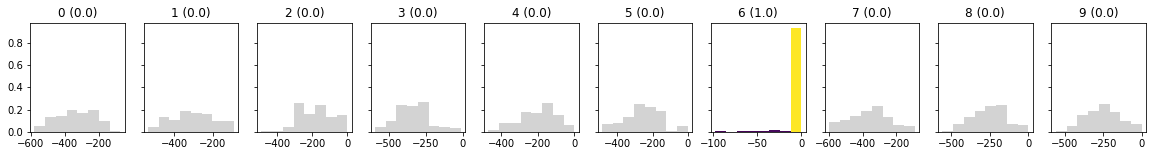

Correct


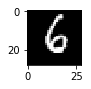

Real:  3


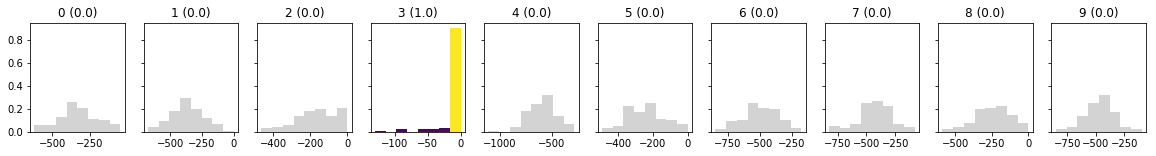

Correct


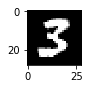

Real:  5


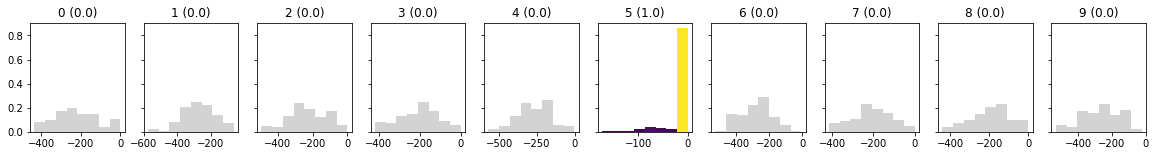

Correct


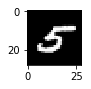

Summary
Total images:  100
Predicted for:  84
Accuracy when predicted:  0.9761904761904762


(100, 82.0, 84)

In [24]:
test_batch(images[:100], labels[:100])